Классификация текстов на категории

In [ ]:
#модуль для загрузки данных, который было предложено использовать в этом домашнем задании
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

In [ ]:
import math
import numpy as np

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from nltk.tokenize import word_tokenize, wordpunct_tokenize
import zipfile
import random
from sklearn.metrics import f1_score
from statistics import 
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
import pylab as pl

from data import Downloader, Parser

Скачаем эмбеддинги

In [ ]:

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [ ]:
# путь к данным
data_path = './data/'

In [ ]:
downloader = Downloader(data_path=data_path)
downloader.run()
parser = Parser(data_path=data_path)
unlabeled, train, valid = parser.run()

Reading: 100%|█████████████████████████████████████████████████████████████████████████| 38/38 [04:08<00:00,  6.55s/it]


In [ ]:
# проверим, что в трейне и валидации одинаковые категории
set(train.category.unique().tolist()) == set(valid.category.unique().tolist())

True

In [ ]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())
category2index = {category: index for index, category in enumerate(unique_categories)}
category2index

{'grocery and gourmet food': 0,
 'pet supplies': 1,
 'cell phones and accessories': 2,
 'beauty': 3,
 'baby': 4,
 'office products': 5,
 'sports and outdoors': 6,
 'automotive': 7}

In [ ]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [ ]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        
        text = self.texts[index]
        target = self.targets[index]
        
        return text, target

In [ ]:
#Функция загрузки эмбеддингов взята из семинарской тетрадки
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words 
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [ ]:
vocab, embeddings = load_embeddings('D:\ML_HSE\wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|████████████████████████████████████████████████████████████████████████▉| 99999/100000 [00:20<00:00, 4888.98it/s]


In [ ]:
#переведем данные в формат, который будет принимать инициализация датасета
train_x = list(train.question) 
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.targe

In [ ]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [ ]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [ ]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, n_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),  embedding_dim=300, padding_idx=0)
        self.dropout = nn.Dropout(p=0.1)
        self.batch_norm = nn.BatchNorm1d(num_features=300)

        self.cnn_1_1 = torch.nn.Conv1d(in_channels=embeddings.shape[-1], out_channels=200, kernel_size=5)
        self.cnn_1_2 = torch.nn.Conv1d(in_channels=200, out_channels=200, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm1d(num_features=200)

        self.cnn_2_1 = torch.nn.Conv1d(in_channels=200, out_channels=100, kernel_size=2)
        self.cnn_2_2 = torch.nn.Conv1d(in_channels=200, out_channels=100, kernel_size=4)

        self.max_pooling_kernel2 =torch.nn.MaxPool1d(kernel_size = 2)

        self.cnn_n_classes = torch.nn.Conv1d(in_channels = 200, out_channels=n_classes, kernel_size=1)
        self.batch_norm2 = nn.BatchNorm1d(num_features=n_classes)
        
        self.lstm = torch.nn.LSTM(input_size=13, hidden_size=13, bidirectional=True, batch_first=True, num_layers=1)
        self.final_pooling = torch.nn.MaxPool1d(kernel_size = 13) #берем максимальное значение для каждго направлени считывания

       
    def forward(self, x):
        x = self.embedding_layer(x)
        x = x.transpose(-1, -2)
        x = self.batch_norm(x)

        x = self.cnn_1_1(x)
        x = torch.relu(x)
        x = torch.cat((self.cnn_1_2(x), torch.zeros(x.size(0), 200, 2)), dim=2) + x
        x = torch.relu(x)
        x = self.batch_norm1(x)
        x = self.dropout(x)

        #применяем паралельные свертки 
        x = torch.cat((self.max_pooling_kernel2(self.cnn_2_1(x)),  torch.cat((self.max_pooling_kernel2(self.cnn_2_2(x)), torch.zeros(x.size(0), 100, 1)), dim=2)), dim=1)

        x = self.cnn_n_classes(x)
        x = self.batch_norm2(x)
        
        #Sparital dropout
        if self.training:
            for i in x:
                for j in i.t():
                    if random.random() < 0.1:
                        j *= 0
            

        x = self.lstm(x)[0]
        x = self.final_pooling(x)
        x = torch.mean(x,  2) 
        return x
   
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            outputs = self.forward(x)
            predictions = torch.softmax(output, 1)
        return torch.max(predictions,1).indices

In [ ]:
def train_epoch(model, loader, criterion, optimizer):
  train_losses = []
  train_f1 = []
  model.train()
  current_epoch_iterations = 0
  for x, y in train_loader:
      output = model(x)
      loss = criterion(output, y)
      train_losses.append(float(loss))
      predictions = torch.softmax(output, 1)
      train_f1.append(f1_score(torch.max(predictions, 1)[1], y, average='micro'))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      current_epoch_iterations  += 1
  return train_losses, train_f1
      

In [ ]:
def valid(model, valid_loader, max_valid_iterations=10):
    valid_losses = []
    valid_f1 = []
    n_valid=0
    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model.forward(x)
            loss = criterion(output, y)
            valid_losses.append(float(loss))
            predictions = torch.softmax(output, 1)
            valid_f1.append(f1_score(torch.max(predictions, 1)[1], y, average='micro'))
            n_valid += 1
            if n_valid == max_valid_iterations:
                break
    return valid_losses, valid_f1

In [ ]:
criterion = nn.CrossEntropyLoss()
test_model = DeepAverageNetwork(embeddings=embeddings, n_classes=len(category2index))
#для эмбеддингов (при инициализации использованы предобученные эмбеддинги) установим меньший learning rate, чем для остальных слоев
optimizer = torch.optim.Adam([ {'params': test_model.embedding_layer.parameters(), 'lr': 1e-6},
                              {'params': test_model.cnn_1_2.parameters()},
                              {'params': test_model.cnn_2_1.parameters()},
                              {'params': test_model.cnn_2_2.parameters()},
                              {'params': test_model.lstm.parameters()}], 
                               lr = 1e-3)

In [ ]:
train_losses = []
train_epoch_losses = []
valid_epoch_losses = []

train_f1 = []
train_epoch_f1 = []
valid_epoch_f1 = []
n_epochs = 15
for epoch in tqdm(range(n_epochs)):
    current_epoch_train_losses, current_epoch_train_f1 = train_epoch(model, train_loader, criterion, optimizer, train_losses)
    mean_train_loss = mean(current_epoch_train_losses)
    train_losses += current_epoch_train_losses
    tqdm.write(str(mean_train_loss))
    train_epoch_losses.append(mean_train_loss)
    train_epoch_f1.append(mean(current_epoch_train_f1))
    current_epoch_valid_losses, current_epoch_valid_f1 = valid(model, valid_loader)
    valid_epoch_losses.append(mean(current_epoch_valid_losses))
    valid_epoch_f1.append(mean(current_epoch_valid_f1))
    ##ранняя остановка, если две эпохи подряд не улучшается f-мера на валидации
    if len(valid_epoch_f1) > 1:
        if valid_epoch_f1[-2] >  valid_epoch_f1[-1]:
            not_better_epochs_counter +=1
        else:
            not_better_epochs_counter = 0   
    if not_better_epochs_counter == 2:
        break

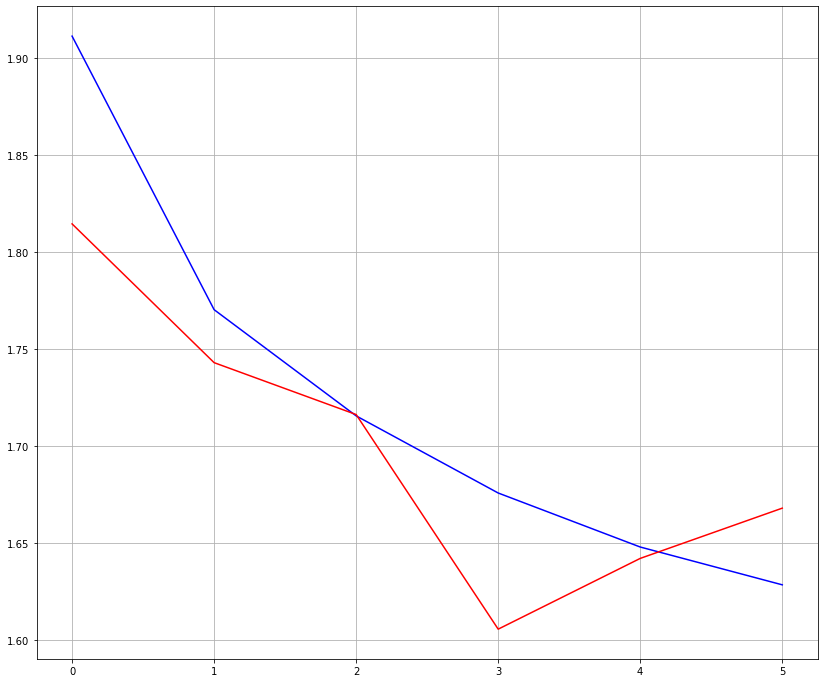

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_epoch_losses, 'b')
plt.plot(valid_epoch_losses, 'r')
plt.grid()

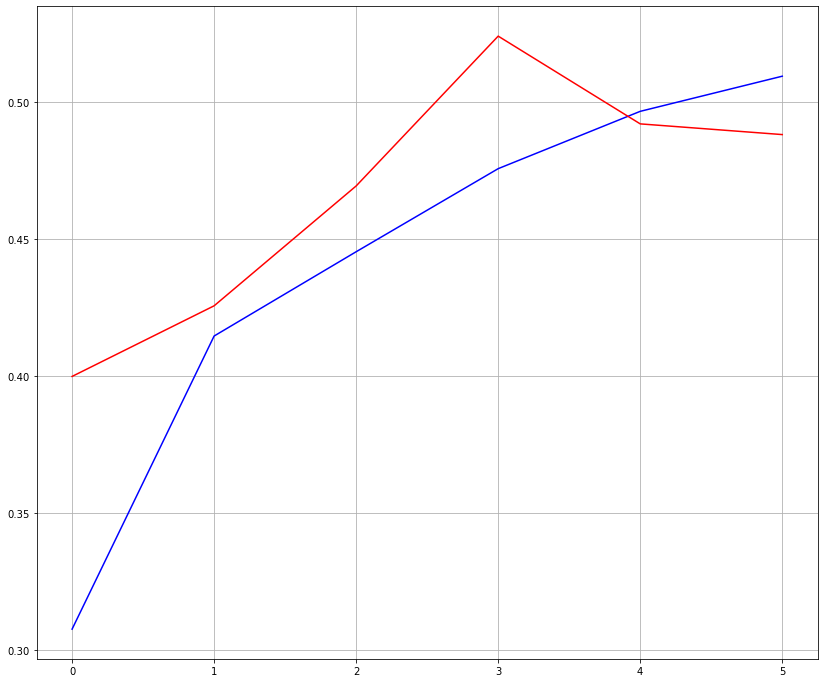

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_epoch_f1, 'b')
plt.plot(valid_epoch_f1, 'r')
plt.grid()

Чтобы посмотреть на качество предсказаний по классам, построим confusion_matrix

In [ ]:
iterations = 0
for x, y in valid_loader:
    y4matrix = [int(i) for i in y]
    pred4matrix = [int(i) for i in test_model.predict(x)]
    iterations += 1
    if iterations == 20:
        break

In [ ]:
cm = confusion_matrix(y4matrix, pred4matrix)

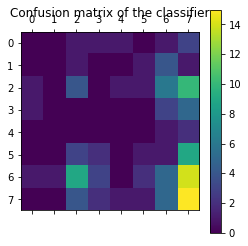

In [ ]:
import pylab as pl
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

F-мера получилась довольно низкой,  в данных был дисбаланс классов + модель часто ошибается (клетка с наибольшим значением соответствует правильному ответу, но не на всех батчах получается так); при перезапусках на других батчах наблюдалась такая же ситуация, но клетка с максимумом не была постоянной. диагональ никогда не была отчетливо выражена - видимо, улушение метрик происходило в основном за счет преобладающего класса

К сожалению, из-за того, что эпоха обучалась долго, не получилось попробовать разные конфигурации сети. Из изменений, которые я совершала, лучше всего на результате сказалось добавление дропаутов и нормализации по батчу (добавляла одновременно, поэтому сравнить их вклад не могу). До добавление дропаута перед lstm валидация быстро начинала уступать трейну

Иногда получалось, что ф-мера на валидации долго колебалась вокруг одной точки, но не попадала в условие остновки, так как не падала две эпохи подряд. Наверно, стоил подобрать какое-то количественное условие прекращения.

